In [1]:
import warnings;
warnings.filterwarnings('ignore')

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Uploading the devices dataset
devices = pd.read_csv('rev-devices.csv')

In [4]:
devices.head(3)

,brand,user_id
0,Android,user_3257
1,Apple,user_6809
2,Android,user_9144


In [5]:
#Uploading the notifications dataset
notifications = pd.read_csv('rev-notifications.csv')

In [6]:
notifications.head(2)

,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6598,2018-12-01 23:09:37.367127


In [7]:
#Uploading the Transactions dataset
transactions = pd.read_csv('rev-transactions.csv')

In [8]:
#bbb = transactions.set_index('user_id')
transsactions = transactions.set_index('user_id')

In [9]:
#trans.head(2)
transsactions.head(2)

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,created_date
user_id,,,,,,,,,,,
user_898,transaction_0,TRANSFER,AED,4.55,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,2018-04-03 03:34:21.784487
user_1652,transaction_1,CARD_PAYMENT,AED,15.50,COMPLETED,FALSE,4111.0,Dubai,ARE,OUTBOUND,2019-03-19 06:15:59.537032


In [10]:
# Not only were the 
transactions.direction.value_counts()

OUTBOUND    2209795
INBOUND      530280
Name: direction, dtype: int64

In [11]:
# Extracting succesful/completed outbound transactions
outbound_successful_transactions = transactions[(transactions.transactions_state == 'COMPLETED') & (transactions.direction =='OUTBOUND')]

In [12]:
# ost means outbound successful  transactions
ost = outbound_successful_transactions

In [13]:
# Selection the useful categories of outbound transactions 
lista = ['TRANSFER', 'CARD_PAYMENT', 'ATM', 'TOPUP',]

ost_final = ost[ost.transactions_type.isin(lista)]

In [14]:
ost_final = ost_final.loc[:,['user_id','amount_usd','created_date']]

In [15]:
ost_final['date'] = pd.to_datetime(ost_final.created_date).dt.date

In [16]:
ost_final.drop('created_date', axis = 1, inplace = True)

In [17]:
ost_final.head(2)

,user_id,amount_usd,date
0,user_898,4.55,2018-04-03
1,user_1652,15.50,2019-03-19


In [18]:
ost_final.shape

(1783491, 3)

In [19]:
# final collection of features from the transactions data set
trans_final = ost_final

In [20]:
users = pd.read_csv('rev-users.csv')

In [21]:
# Extracting users age and plan dataset

users_birthyear_plan = users.loc[:,['user_id','birth_year','plan']]

In [22]:
# Merging portions of the transaction data and the users_birthyear_plan data sets

merge_data = pd.merge(trans_final,users_birthyear_plan)

In [23]:
merge_data['date'] = pd.to_datetime(merge_data.date)
merge_data['week'] = merge_data.date.dt.year.astype(str) + '-w' + merge_data.date.dt.week.astype(str)

In [24]:
# Sorting and renaming the new dataset

merge_data_sorted = merge_data.sort_values(['user_id','date']) 

In [25]:
# Selecting our final columns for transformation and modeling

data_summary = merge_data_sorted.loc[:,['user_id','amount_usd','date','week', 'birth_year']]


# Extraction and transformation of data

In [26]:
customers = list(data_summary.user_id.unique())
user_id = []
active_days = []
days_on_platform = []
total_out_bound = []
age = []
num_of_visits = []
#ts = pd.to_datetime('2019')

for i in range(len(customers)):
    fack = data_summary[data_summary['user_id'] == customers[i]]
    total_out_bound.append(fack.amount_usd.sum())
    days_on_platform.append(str(fack.date.max() - fack.date.min()).split(' ')[0])
    active_days.append(len(fack.date.unique()))
    user_id.append(customers[i])
    age.append(2019 -(fack.birth_year.unique()[0]))
    num_of_visits.append(fack.shape[0])
    




users_id = user_id

DOP = days_on_platform

ADS = active_days

TOB = total_out_bound

AGE = age

NOV = num_of_visits
                              

In [27]:
# Creating the dataframe'

data_dict ={'users_id':user_id,'DOP':days_on_platform,'ADS':active_days,'TOB':total_out_bound,'NOV':num_of_visits,'AGE':age}
data2 = pd.DataFrame(data_dict)#.replace([np.inf, -np.inf], 0).fillna(0).astype('float')
data2.columns = ['user_id','days_on_platform','active_days','total_out_bound','num_of_visits','age']

In [28]:
# Segmenting users into age groups
bins = [0,31,46,61,76, 100]
group_names = ['young', 'middle_age', 'family_type', 'established','retired']
data2['grade'] = pd.cut(data2['age'], bins, labels = group_names)

In [29]:
#Calculating the ratio for days_on_platform
data2['days_on_platform'] = data2['days_on_platform'].astype('float32')

In [30]:
#calculating ratio of active days for all users
data2['ratio_of_active_days'] = (data2.active_days)/(data2.days_on_platform)

In [31]:
# Checking for negative values
data2 = data2.replace([np.inf, -np.inf], 0)#.fillna(0)

In [32]:
data2.describe()

,days_on_platform,active_days,total_out_bound,num_of_visits,age,ratio_of_active_days
count,17059.000000,17059.000000,17059.000000,17059.000000,17059.000000,17059.000000
mean,190.075623,42.707838,3667.196587,104.548391,35.063251,0.237796
std,128.667328,53.448837,12781.221391,181.528295,11.189022,0.264026
min,0.000000,1.000000,0.010000,1.000000,18.000000,0.000000
25%,90.000000,7.000000,288.995000,11.000000,27.000000,0.066153
50%,183.000000,22.000000,1130.920000,40.000000,32.000000,0.150127
75%,287.000000,57.000000,3344.840000,115.000000,41.000000,0.321429
max,493.000000,458.000000,717087.680000,3385.000000,90.000000,2.000000


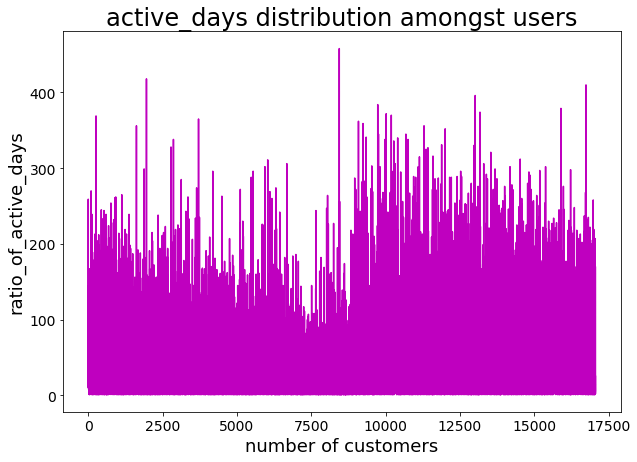

In [33]:
# Finding out if there was any pattern/cluster in the active_days 
data2.active_days.plot(figsize=(10,7), color = ('m'))
plt.title('active_days distribution amongst users', fontsize = (24))
plt.xlabel('number of customers', fontsize = (18))
plt.ylabel('ratio_of_active_days', fontsize = (18))
plt.tick_params(labelsize = 14)

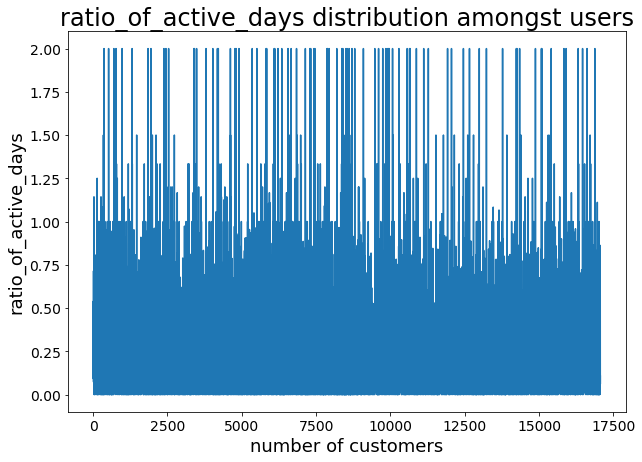

In [34]:
# Finding out if there was any pattern/cluster in the ratio_of_active_days 
# Most of the population concentrated around the cut off mark for likely to churn or not. 

data2.ratio_of_active_days.plot(figsize=(10,7))
plt.title('ratio_of_active_days distribution amongst users', fontsize = (24))
plt.xlabel('number of customers', fontsize = (18))
plt.ylabel('ratio_of_active_days', fontsize = (18))
plt.tick_params(labelsize = 14)

# Segmentation of customers.

### The goal of this report is to find out if the ratio_of_active_days is a good measure to separate 
### customers into two groups;
#### 1) Those likely to churn (label = 1)
#### 2) Those not likely to churn (label = 0)

##### the customers were separated into 3 groups. Those with a ratio_of_active_days ratio greater than 0.4, second
##### group had a ratio between 0.1 and 0.4 and the last group had a ratio of less than 1.

##### Those with a ratio_of_active_days ratio less than 0.1 meant they did transactions once or less every 10days. The members of this group are most likely to have numerous accounts. It can be interesting to find out from other sources what the purchasing habit of this group is. 

In [35]:
# Customers who did four or more transactions every 19days.
ratio_1 = data2[data2['ratio_of_active_days'] >= 0.4]

# Customrs who did between 1 and <4 transactions every 10days
ratio_2 = data2[(data2['ratio_of_active_days'] < 0.4) & (data2['ratio_of_active_days'] >= 0.10)]

# Customers who carried out less than one transaction in 10days
ratio_3 = data2[data2['ratio_of_active_days'] < 0.10]

# Correlations
### Performimg a pairplot gives an idea of the relationship between different columns which can
### further exploited. Looking at the plots it is evident that there is a linear relationship between the
### active_days columns and the ratio_of_active_days. This can be easily explained since our dataset was
### for a finit period of time.
### Unfortunately this did not translate to increase in completed outbound transactions.

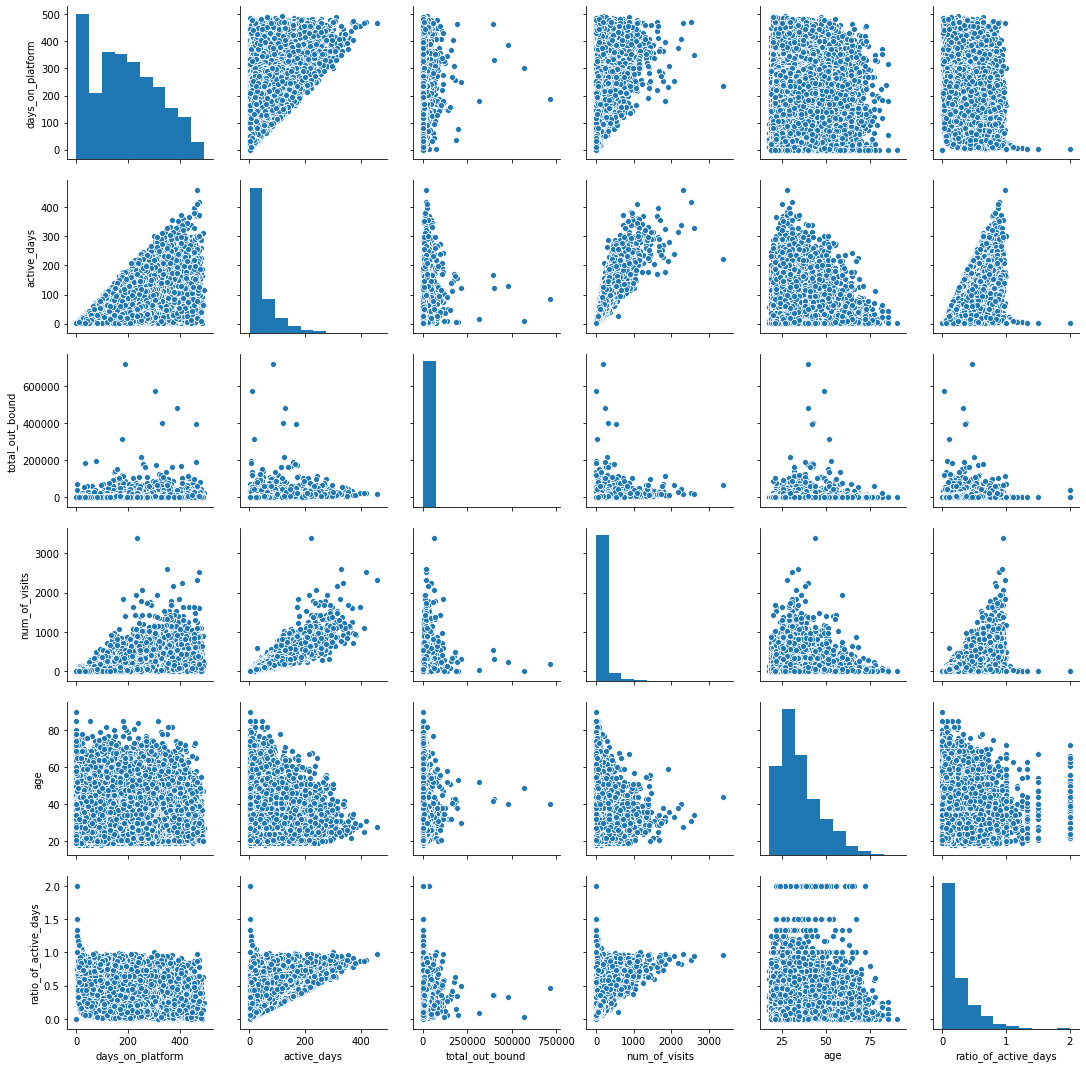

In [36]:
#Visual check for correlation between features
import seaborn as sns
sns.pairplot(data=data2)

In [37]:
# Checking for correlation between days_on_platform and active_days
data2 ['days_on_platform'].corr(data2['active_days'], method = 'pearson')

0.540312526576724

<Figure size 1440x720 with 0 Axes>

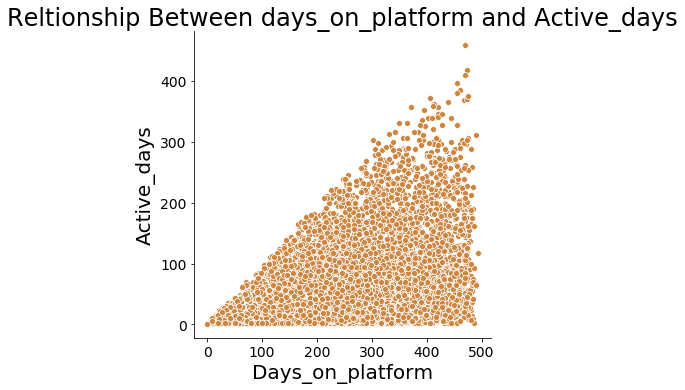

<Figure size 1440x720 with 0 Axes>

In [38]:
# Detailed examination of the correlation between days_on_platform and Active_days
sns.relplot(x='days_on_platform', y= 'active_days', data = data2, color = 'peru')

plt.title('Reltionship Between days_on_platform and Active_days', fontsize = 24)
plt.ylabel('Active_days', fontsize = 20)
plt.xlabel('Days_on_platform', fontsize = 20)
plt.tick_params(labelsize = 14)
plt.figure(figsize = (20,10))

In [39]:
#checking for correlation
data2 ['days_on_platform'].corr(data2['total_out_bound'], method = 'pearson')

0.18951954856293846

In [40]:
#checking for correlation
data2 ['total_out_bound'].corr(data2['active_days'], method = 'pearson')

0.30133270242906085

In [41]:
#checking for correlation
data2 ['num_of_visits'].corr(data2['total_out_bound'], method = 'pearson')

0.2901177210917025

<Figure size 1440x720 with 0 Axes>

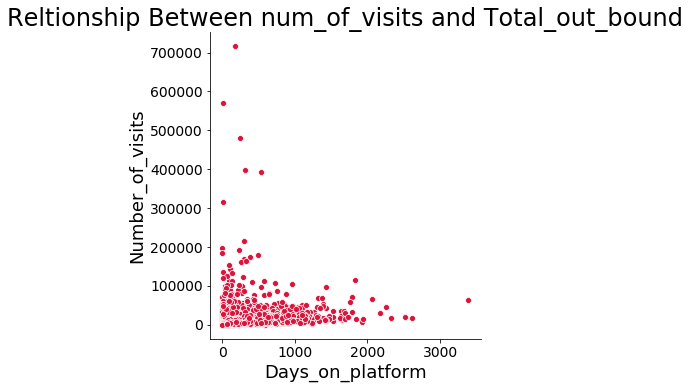

<Figure size 1440x720 with 0 Axes>

In [42]:
# scatter plot to check for correlation between number_of_visits and Days_on_platform

sns.relplot(x='num_of_visits', y= 'total_out_bound', data = data2, color = 'crimson')

plt.title('Reltionship Between num_of_visits and Total_out_bound', fontsize = 24)
plt.ylabel('Number_of_visits', fontsize = 18)
plt.xlabel('Days_on_platform', fontsize = 18)
plt.tick_params(labelsize = 14)
plt.figure(figsize = (20,10))

In [43]:
# Separating the customers into those likely to churn or not

rates = list(data2.ratio_of_active_days)
list1 = range(len(rates))

categories = []

for i in list1:
    if rates[i] >= 0.1:
        categories.append(0)
    else:
        categories.append(1)
        
data2['category'] = categories

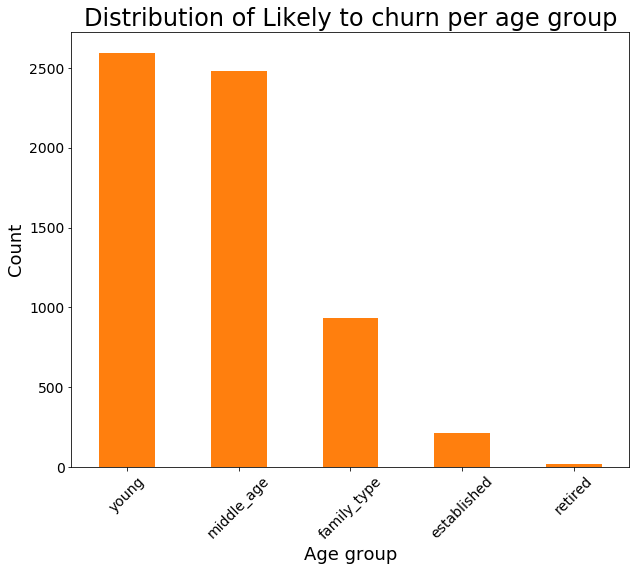

In [44]:
# Checking the distribution of age groups in the category of likely to churn
data2[data2.category == 1].groupby('grade').count().plot(kind = 'bar', figsize = (10,8), color = ('tab:orange'), legend = False)
plt.title('Distribution of Likely to churn per age group', fontsize = 24)
plt.xlabel('Age group', fontsize = 18)
plt.ylabel('Count', fontsize = 18)


plt.xticks( rotation=45)
plt.tick_params(labelsize = 14)

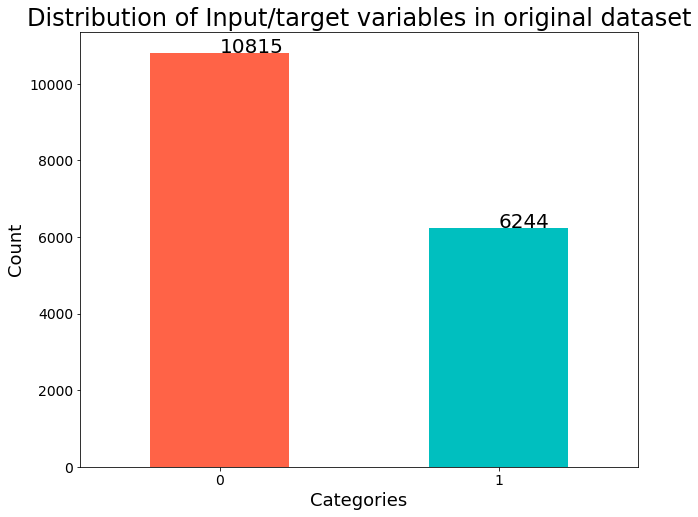

In [45]:
# Visualizing the class imbalance in the data set
data2.category.value_counts().plot(kind = 'bar', figsize = (10,8), color = ('tomato','c'))


plt.title('Distribution of Input/target variables in original dataset', fontsize = 24)
plt.ylabel('Count', fontsize = 18)
plt.xlabel('Categories', fontsize = 18)
plt.xticks( rotation=360)
plt.tick_params(labelsize = 14)
#plt.figure(figsize = (20,10))
n = [0,1]
for i in range(len(data2.category.value_counts())):
    plt.annotate(str(data2.category.value_counts()[i]), xy=(n[i],data2.category.value_counts()[i]), 
                 fontsize = 20)

plt.show()


# Logistic regression
## Explain the ratios of the categories 1 and 0

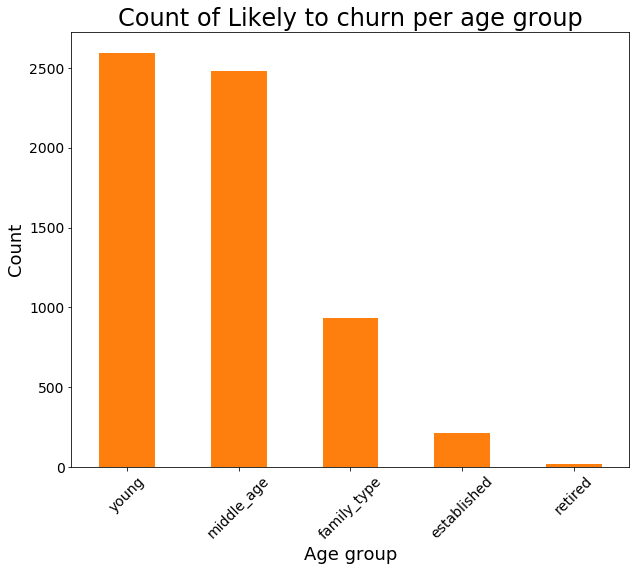

In [46]:
# Age group distribution in the likely to churn category

data2[data2.category == 1].groupby('grade').count().plot(kind = 'bar', figsize = (10,8), color = ('tab:orange'), legend = False)
plt.title('Count of Likely to churn per age group', fontsize = 24)
plt.xlabel('Age group', fontsize = 18)
plt.ylabel('Count', fontsize = 18)


plt.xticks( rotation=45)
plt.tick_params(labelsize = 14)

In [47]:
# Dropping the user_id column selecting features for the model

final_data = data2.loc[:,['days_on_platform', 'active_days', 'total_out_bound',
       'num_of_visits', 'ratio_of_active_days', 'category']].dropna().astype('float32')


X_var = final_data[final_data.columns[:-1]]
y_var = final_data[final_data.columns[-1]]

# Feature scaling

In [48]:
# Normalizing the input variables
scaler = StandardScaler().fit(X_var)
X_scaled = scaler.transform(X_var)
X_variable = X_scaled

#Splitting the data into into train and test sets after normalization of input features
X_train, X_test, y_train, y_test = train_test_split(X_variable, y_var, test_size=0.3, random_state=0)

# Selecting the best features for our algorithm with;

### Recursive feature elimination

### SelectBest.

In [49]:

from sklearn.feature_selection import SelectKBest, chi2
bestfeatures = SelectKBest(score_func = chi2, k = 3)
fit = bestfeatures.fit(X_var,y_var)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(final_data.columns[:-1])

# concating the two frames for better visualizations
featureScores = pd.concat([dfcolumns,dfscores], axis = 1)

# Naming the dataframe columns
featureScores.columns = ['Specs', 'Score']

#Ranking our features based on importance
featureScores.sort_values(by = ['Score'])

,Specs,Score
4,ratio_of_active_days,1.526647e+03
0,days_on_platform,1.348786e+04
1,active_days,2.465188e+05
3,num_of_visits,7.179217e+05
2,total_out_bound,1.345626e+07


# Resolving over sampling

In [50]:
#df_os_X_train = pd.DataFrame(data = X_train,columns = X_var.columns)

#df_os_y_train = pd.DataFrame(data = y_train,columns = ['category'])

df_X_train = pd.DataFrame(data = X_train,columns = X_var.columns)

df_y_train = pd.DataFrame(data = y_train,columns = ['category'])



os = SMOTE(random_state=0)


os_X_train, os_y_train = os.fit_sample(df_X_train, df_y_train)

import warnings;
warnings.filterwarnings('ignore')

In [51]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
predictors = os_X_train
selector = RFE(logreg, n_features_to_select = 1)
selector = selector.fit(predictors, os_y_train)
order = selector.ranking_



feature_ranks = []
for i in order:
    feature_ranks.append(f'{i}:   {X_var.columns[i-1]}')
feature_ranks

['3:   total_out_bound',
 '2:   active_days',
 '5:   ratio_of_active_days',
 '4:   num_of_visits',
 '1:   days_on_platform']

In [52]:
X_train_set = pd.DataFrame(data = os_X_train,columns = X_var.columns)

y_train_set = pd.DataFrame(data = os_y_train,columns = ['category'])

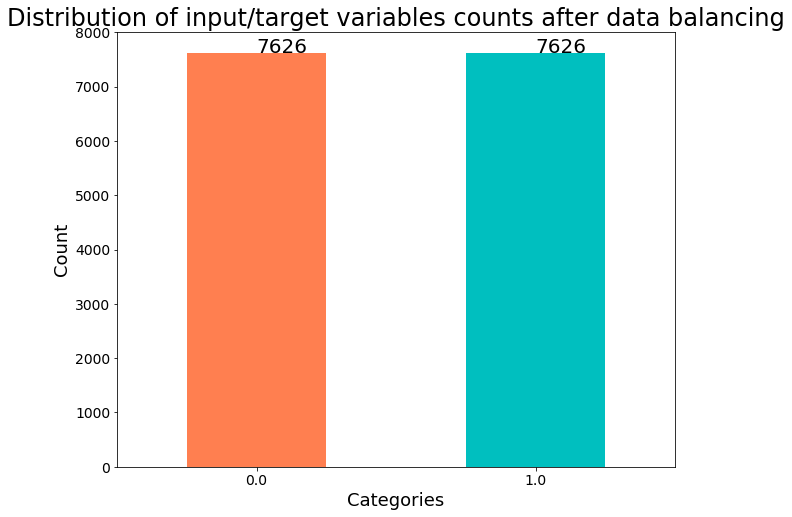

In [53]:
# data2.category.value_counts().plot('bar')
y_train_set.category.value_counts().plot(kind = 'bar', color = ('coral','c'), figsize = (10,8))


plt.title('Distribution of input/target variables counts after data balancing', fontsize = 24)
plt.ylabel('Count', fontsize = 18)
plt.xlabel('Categories', fontsize = 18)


n = [0,1]

for i in range(len(y_train_set.category.value_counts())):
    plt.annotate(str(y_train_set.category.value_counts()[i]), xy=(n[i],y_train_set.category.value_counts()[i]), 
                 fontsize = 20)


plt.xticks( rotation=360)
plt.tick_params(labelsize = 14)

# Implementing the model

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
log_reg_model = logreg.fit(os_X_train, os_y_train)

print(log_reg_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


## Making predictions and checking accuracy

In [55]:
# Making predictions and checking accuracy

y_pred = log_reg_model.predict(X_test)


# model_accuracy = log_reg_model.score( X_test, y_test )
model_accuracy = log_reg_model.score( X_test, y_pred )
model_accuracy

#from sklearn.metrics import accuracy_score
#print(f'Accuracy score = {accuracy_score(X_test, y_pred)}')

1.0

In [56]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[3142   47]
 [   1 1928]]


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3189
         1.0       0.98      1.00      0.99      1929

    accuracy                           0.99      5118
   macro avg       0.99      0.99      0.99      5118
weighted avg       0.99      0.99      0.99      5118



# ROC plot

5.5595463995353294e-05


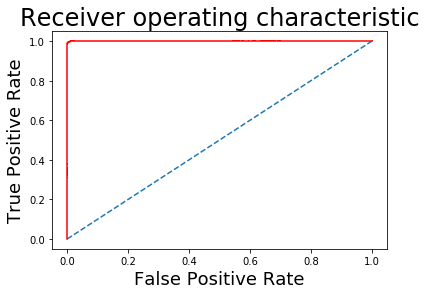

<Figure size 2160x2160 with 0 Axes>

In [58]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
probs = log_reg_model.predict_proba(X_test)
probs = probs[:,0]
auc = roc_auc_score(y_test, probs)
print(auc)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0,1],[0,1], linestyle ='--')
plt.plot(tpr,fpr, marker = ',', color = 'r')
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('Receiver operating characteristic', fontsize = 24)
plt.figure(figsize = (30,30))
plt.show()
#plt.legend(loc="lower right"), 

# Trying the model with less features

In [59]:

# rank_data = data2.loc[:,['active_days', 'total_out_bound', 'num_of_visits','ratio_of_active_days','category']].astype('float32')

rank_data = data2.loc[:,['total_out_bound', 'num_of_visits','ratio_of_active_days','category']]

rank_X_variable = rank_data[rank_data.columns[:-1]]
rank_y_variable = rank_data[rank_data.columns[-1]]

scaler = StandardScaler().fit(rank_X_variable)
X_scaled = scaler.transform(rank_X_variable)
X_scaled



RX_train, RX_test, Ry_train, Ry_test = train_test_split(X_scaled, rank_y_variable, test_size=0.3, random_state=0)




# Balancing the train and test datasets
os_RX_train, os_Ry_train = os.fit_sample(RX_train, Ry_train)



# Training the model
rank_logreg_model = logreg.fit(os_RX_train, os_Ry_train)



# Making predictions and checking accuracy

rank_pred = rank_logreg_model.predict(RX_test)


# model_accuracy = log_reg_model.score( X_test, y_test )
rank_model_accuracy = rank_logreg_model.score( RX_test, rank_pred )
rank_model_accuracy

1.0

In [60]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Ry_test, rank_pred)
print(confusion_matrix)

[[3126   63]
 [   0 1929]]


In [61]:
from sklearn.metrics import classification_report
print(classification_report(Ry_test, rank_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3189
           1       0.97      1.00      0.98      1929

    accuracy                           0.99      5118
   macro avg       0.98      0.99      0.99      5118
weighted avg       0.99      0.99      0.99      5118



# Trying the model again but undersampling the majority class

In [62]:

# The X_variable are scaled already
uX_train, uX_test, uy_train, uy_test = train_test_split(X_variable, y_var, test_size=0.3, random_state=0)



#df_X_train = pd.DataFrame(data = X_train,columns = X_var.columns)

#df_y_train = pd.DataFrame(data = y_train,columns = ['category'])


from imblearn.under_sampling import NearMiss 
nr = NearMiss() 



nr_X_train, nr_y_train = nr.fit_sample(uX_train, uy_train)



from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg_under = LogisticRegression()
logreg_under_model = logreg_under.fit(nr_X_train, nr_y_train)

# Training the model

# Making predictions and checking accuracy

under_pred = logreg_under_model.predict(uX_test)


# model_accuracy = log_reg_model.score( X_test, y_test )
under_model_accuracy = logreg_under_model.score( uX_test, under_pred )
under_model_accuracy




1.0

In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix_under = confusion_matrix(uy_test, under_pred)
print(confusion_matrix_under)

[[3174   15]
 [   7 1922]]


In [64]:
from sklearn.metrics import classification_report
print(classification_report(uy_test, under_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3189
         1.0       0.99      1.00      0.99      1929

    accuracy                           1.00      5118
   macro avg       1.00      1.00      1.00      5118
weighted avg       1.00      1.00      1.00      5118



# Some useful plots for the documentation

In [65]:
data2.columns

Index(['user_id', 'days_on_platform', 'active_days', 'total_out_bound',
       'num_of_visits', 'age', 'grade', 'ratio_of_active_days', 'category'],
      dtype='object')

In [66]:
Average_TOB_in_churn = data2[data2.category ==1].groupby('grade').total_out_bound.mean()
Average_DOP_in_churn = data2[data2.category ==1].groupby('grade').days_on_platform.mean()

In [67]:
Pop_dist = data2.grade.value_counts()
pop_dist_Total = data2.grade.value_counts(normalize = True).mul(100).round(1).astype(str) + '%'
pop_dist_in_churn = data2[data2.category == 1].grade.value_counts(normalize = True).mul(100).round(1).astype(str) + '%'
DOP = data2[data2.category == 1].groupby('grade').days_on_platform.mean()


Total_stats = pd.DataFrame({'Pop_dist':Pop_dist,
                            'pop_dist_Total':pop_dist_Total,
                            'pop_dist_in_churn':pop_dist_in_churn,
                            'Average_TOB_in_churn':Average_TOB_in_churn,
                            'Average_DOP_in_churn':Average_DOP_in_churn})

bins = ['61-75yrs','46-60yrs','31-45yrs','=> 75yrs','=< 30yrs']
Total_stats['age_range'] = bins
total_stats = Total_stats.iloc[[4,2,1,0,3],[5,0,1,2,3,4]]
total_stats
#plt.savefig('/home/ntemi/Desktop/matplotlibfigs/table.png', dpi=300, transparent=True)

,age_range,Pop_dist,pop_dist_Total,pop_dist_in_churn,Average_TOB_in_churn,Average_DOP_in_churn
retired,=< 30yrs,29,0.2%,0.3%,2360.176111,159.611115
family_type,31-45yrs,2214,13.0%,15.0%,2857.648770,168.611771
middle_age,46-60yrs,6428,37.7%,39.8%,1352.510697,177.451874
young,61-75yrs,7912,46.4%,41.6%,977.462054,172.359146
established,=> 75yrs,476,2.8%,3.4%,1466.335493,176.910797


In [68]:
binns = ['young','middle_age']
under_45 = data2[data2.grade.isin(binns)]

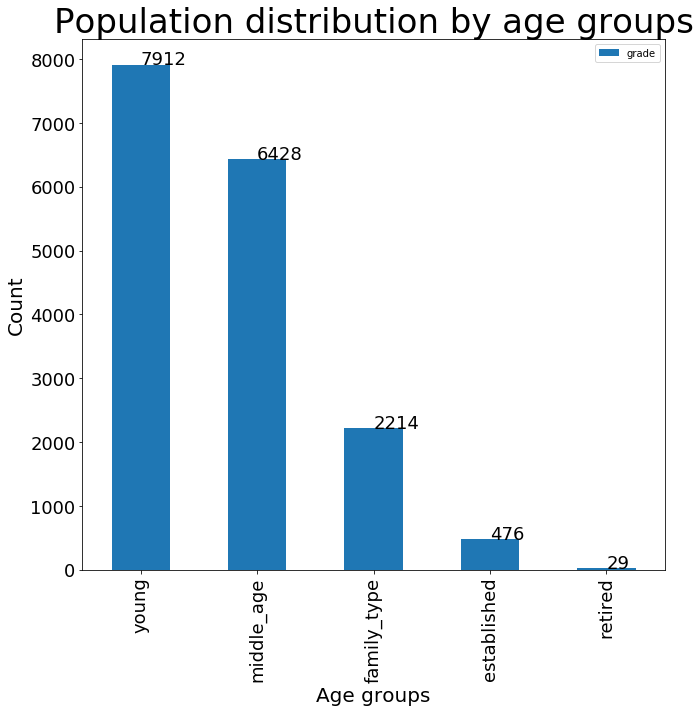

In [69]:
data2.grade.value_counts().plot(kind = 'bar', figsize = (10,10))
n = [0,1,2,3,4]

for i in range(len(data2.grade.value_counts())):
    plt.annotate(str(data2.grade.value_counts()[i]), xy=(n[i],data2.grade.value_counts()[i]), 
                 fontsize = 18)

plt.tick_params(labelsize = 18)
plt.title('Population distribution by age groups', fontsize = 34)
plt.xlabel('Age groups', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('/home/ntemi/Desktop/matplotlibfigs/popdist.png', dpi=300, transparent=True) 
#plt.savefig('popdist')